In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd

from utils.utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = load_data_by_year('2022')
df = clean_raw_data(df)

In [3]:
df_teste = load_data_by_year('2023')
df_teste = clean_raw_data(df_teste)

## Algumas Análises

Testes, Visualizações e Transformações

1. Transformar o target utilizando box-cox traz uma grande diferença?

In [5]:
fitted_data, fitted_lambda = stats.boxcox(df["NU_NOTA_MT"])

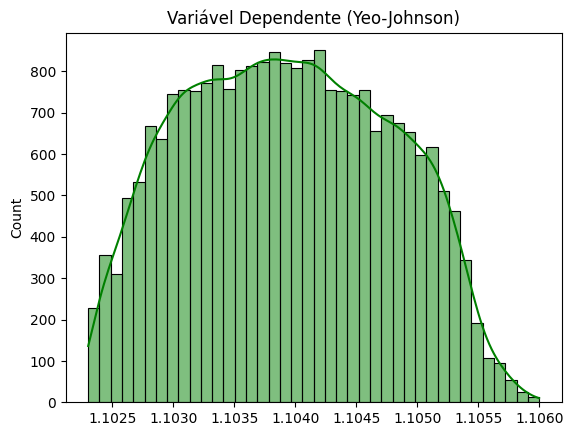

In [6]:
plt.title("Variável Dependente (Yeo-Johnson)")
sns.histplot(fitted_data, kde=True, label = "Non-Normal", color ="green")
plt.show()

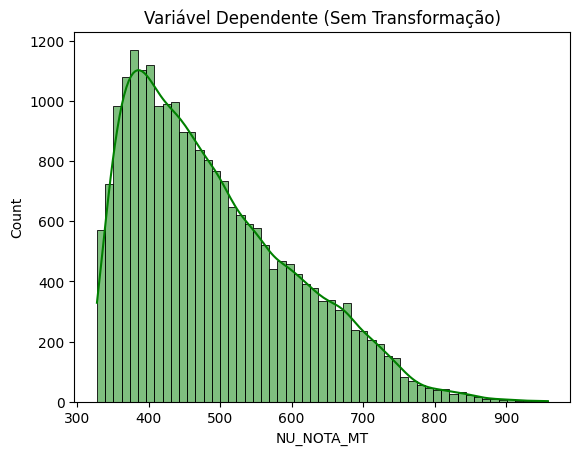

In [7]:
plt.title("Variável Dependente (Sem Transformação)")
sns.histplot(df["NU_NOTA_MT"], kde=True, label = "Normal*", color ="green")
plt.show()

In [8]:
df["NU_NOTA_MT"].mean()

490.1717580372983

Houve uma mudança significativa após a transformação

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import numpy as np
from numpy import absolute

In [10]:
X = pd.get_dummies(df.drop(columns=['NU_NOTA_MT'], errors="ignore"), drop_first=True)
y = df["NU_NOTA_MT"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [12]:
model = GradientBoostingRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring="r2", cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean R²: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean R²: 0.613 (0.013)


In [13]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [14]:
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Função para calcular as métricas de avaliação
def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(45*"-")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"MSE (Mean Squared Error): {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"R² (Coeficiente de Determinação): {r2:.4f}")
    print(45*"-")

In [16]:
print_metrics(y_test, y_pred)

---------------------------------------------
MAE (Mean Absolute Error): 56.4897
MSE (Mean Squared Error): 5064.8082
RMSE (Root Mean Squared Error): 71.1675
R² (Coeficiente de Determinação): 0.6091
---------------------------------------------


## Pycaret

1. Etapa de Auto ML (Com Pycaret)

In [4]:
from pycaret.regression import *

In [8]:
# Creating a pipeline to setup the model
pipeline = setup(
    data=df,
    test_data=df_teste,
    index=False,
    target='NU_NOTA_MT',
    # Imputation
    imputation_type=None, #Não precisa preencher valores nulos
    # Multicolinearidade
    remove_multicollinearity=True, #Remover colunas que contem multicolinearidade
    multicollinearity_threshold=0.95,
    # Normalização das variáveis
    normalize=True, 
    normalize_method='minmax',
    transform_target=False,
    # Seleção de Variáveis
    feature_selection=True, #Habilitando Feature Selection para reduzir a dimensionalidade
    feature_selection_method='classic', #Feature Selection com SelectModel 
    n_features_to_select=0.25, #Selecionar 1/4 das variáveis mais relevantes
    session_id=1991
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 20423, number of used features: 161
[LightGBM] [Info] Start training from score 505.257235


,Description,Value
0,Session id,1991
1,Target,NU_NOTA_MT
2,Target type,Regression
3,Original data shape,"(43534, 45)"
4,Transformed data shape,"(43534, 12)"
5,Transformed train set shape,"(20423, 12)"
6,Transformed test set shape,"(23111, 12)"
7,Numeric features,4
8,Categorical features,40
9,Preprocess,True


In [10]:
compare_models(fold=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,57.9680,5170.7557,71.8929,0.5154,0.1425,0.1181,4.3880
lightgbm,Light Gradient Boosting Machine,58.1719,5218.7923,72.2241,0.5108,0.1431,0.1184,41.7020
rf,Random Forest Regressor,59.5874,5486.4224,74.0562,0.4859,0.1469,0.1215,8.3920
xgboost,Extreme Gradient Boosting,60.1193,5618.7817,74.9380,0.4736,0.1482,0.1222,3.2770
ridge,Ridge Regression,60.5846,5649.4600,75.1492,0.4706,0.1496,0.1236,2.8600
lar,Least Angle Regression,60.5802,5649.3932,75.1488,0.4706,0.1496,0.1236,2.8590
br,Bayesian Ridge,60.5828,5649.4304,75.1490,0.4706,0.1496,0.1236,2.9770
lr,Linear Regression,60.5802,5649.3932,75.1488,0.4706,0.1496,0.1236,2.9980
huber,Huber Regressor,60.5094,5659.5274,75.2160,0.4695,0.1501,0.1232,3.1430
et,Extra Trees Regressor,60.6481,5684.4454,75.3783,0.4672,0.1495,0.1236,6.0030


GradientBoostingRegressor(random_state=1991)

In [9]:
model = create_model('gbr', fold=10, round=3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,58.217,5173.757,71.929,0.532,0.141,0.117
1,57.673,5079.558,71.271,0.520,0.141,0.117
2,56.808,4895.561,69.968,0.532,0.139,0.116
3,56.003,4858.528,69.703,0.524,0.139,0.114
4,57.853,5186.727,72.019,0.533,0.142,0.117
5,59.413,5482.587,74.044,0.524,0.144,0.118
6,58.857,5363.699,73.237,0.560,0.143,0.118
7,58.961,5323.218,72.960,0.496,0.146,0.121
8,56.386,4941.722,70.297,0.500,0.141,0.117


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [50]:
tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,56.1596,4881.3096,69.8664,0.6139,0.1451,0.1203
1,56.5700,5132.9251,71.6444,0.5860,0.1460,0.1196
2,56.9346,5118.5907,71.5443,0.6102,0.1452,0.1186
3,58.0361,5483.0408,74.0476,0.5621,0.1502,0.1219
4,57.1906,5309.9109,72.8691,0.6190,0.1478,0.1194
5,56.9417,5124.3009,71.5842,0.5906,0.1463,0.1200
6,57.5891,5333.0082,73.0274,0.6060,0.1478,0.1194
7,54.7288,4762.8607,69.0135,0.6149,0.1420,0.1162
8,57.3223,5210.2008,72.1817,0.5707,0.1484,0.1221


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


GradientBoostingRegressor(random_state=1991)

In [11]:
df_predict = predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,61.3629,5624.9364,74.9996,0.5643,0.1571,0.1352


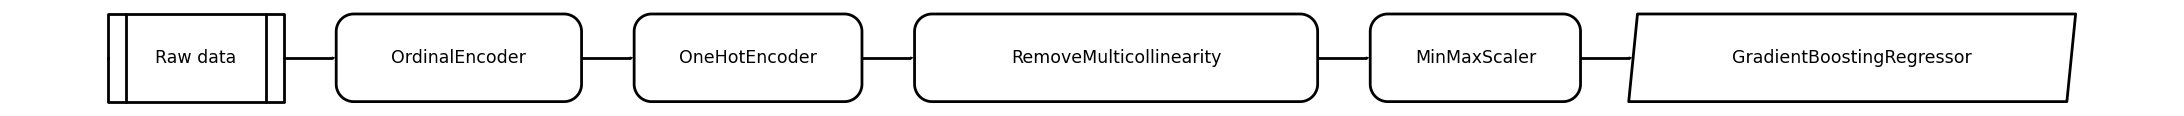

In [39]:
plot_model(model, 'pipeline')

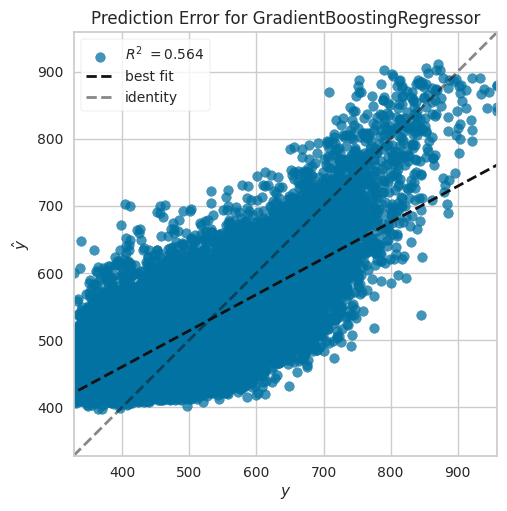

In [12]:
plot_model(model, 'error')

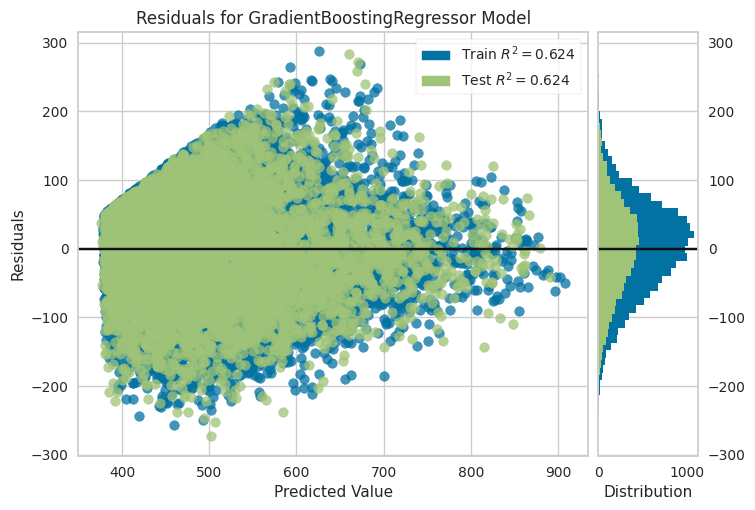

In [53]:
plot_model(model, 'residuals')

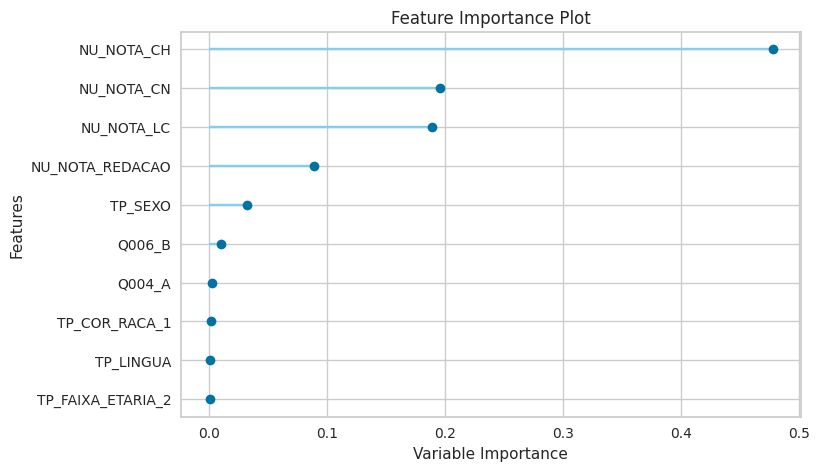

In [54]:
plot_model(model, "feature")

In [56]:
df_predict[["NU_NOTA_MT", "prediction_label"]].head()

,NU_NOTA_MT,prediction_label
36028,624.799988,607.161503
74480,430.299988,430.573934
64038,570.200012,709.367378
75899,396.000000,428.267783
84251,788.000000,825.330762


In [ ]:
save_model(model, '../models/saved_gbr_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('ordinal_encoding',
                  TransformerWrapper(include=['TP_SEXO', 'TP_ENSINO',
                                              'TP_LOCALIZACAO_ESC', 'TP_LINGUA',
                                              'Q018', 'Q020', 'Q021', 'Q023',
                                              'Q025'],
                                     transformer=OrdinalEncoder(cols=['TP_SEXO',
                                                                      'TP_ENSINO',
                                                                      'TP_LOCALIZACAO_ESC',
                                                                      'TP_LINGUA',
                                                                      'Q018',
                                                                      'Q020',
                                                                      'Q021',
                                                                 